In [1]:
%load_ext autoreload
%autoreload 2

from functions import *
from tqdm import *

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor, plot_importance
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from collections import defaultdict

import true_preprocessing

c:\Users\malth\OneDrive - University of Copenhagen\Bachelor\programs\true_preprocessing.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X_4 = X_3 / np.sum(X_3, axis=1)[:, np.newaxis]


# Sanity check specific functions

In [2]:
scorer = make_scorer(mean_squared_error)

In [3]:
def dummy_CV(X, y):
    ref_scores = []
    for i in range(5):
        kf = KFold(n_splits=5, shuffle=True, random_state=1)
        dummy = DummyRegressor(strategy="mean")
        ref_scores.append(np.mean(cross_val_score(dummy, X, y, scoring=scorer, cv=kf)))
    return ref_scores

def SVM_CV(X, y):
    # Define outer cross-validation splits
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create lists to store results
    results_params = []; results_scores = []

    # Perform nested cross-validation
    for train_ix, test_ix in cv_outer.split(X):
        # Split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
        
        # Define the model and parameters
        model = SVR()
        parameters = {"C": [1, 10, 100], "gamma": [.001, .01, .1]}

        # Define and do search
        search = GridSearchCV(model, parameters, scoring=scorer, cv=cv_inner, refit=True, n_jobs=6)
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set and evaluate it on the holdout set
        best_model = result.best_estimator_
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = mean_squared_error(y_test, yhat)
        
        # Report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        #outer_results.append([acc, result.best_score_, result.best_params_])
        results_scores.append(acc)
        results_params.append(result.best_params_)
    return results_scores, results_params

    # Summarize the estimated performance of the model
    #print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

def logistic_CV(X, y):
    # Define outer cross-validation splits
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create lists to store results
    results_params = []; results_scores = []
    # Perform nested cross-validation
    for train_ix, test_ix in cv_outer.split(X):
        # Split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
        
        # Define the model and parameters
        model = Lasso()
        parameters = {'alpha':list(np.logspace(-4,2,7,10))}

        # Define and do search
        search = GridSearchCV(model, parameters, scoring=scorer, cv=cv_inner, refit=True, n_jobs=6)
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set and evaluate it on the holdout set
        best_model = result.best_estimator_
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = mean_squared_error(y_test, yhat)
        
        # Report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        results_scores.append(acc)
        results_params.append(result.best_params_)
    return results_scores, results_params

def rf_CV(X, y):
    # Define outer cross-validation splits
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create lists to store results
    results_params = []; results_scores = []

    # Perform nested cross-validation
    for train_ix, test_ix in cv_outer.split(X):
        # Split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
        
        # Define the model and parameters
        model = RandomForestRegressor(random_state=1, n_jobs=6)
        parameters = {'n_estimators':np.linspace(50,1000,4,True,dtype=int), 'max_features':np.linspace(0.05,0.9,4,True)}

        # Define and do search
        search = GridSearchCV(model, parameters, scoring=scorer, cv=cv_inner, refit=True, n_jobs=6)
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set and evaluate it on the holdout set
        best_model = result.best_estimator_
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = mean_squared_error(y_test, yhat)
        
        # Report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        results_scores.append(acc)
        results_params.append(result.best_params_)
    return results_scores, results_params

def rename_columns(X):
    new_columns = [f"feature_{i}" for i in range(len(X.columns))]
    X.columns = new_columns
    return X

def XGB_CV(X, y):
    #Transform classes to numbers and feature names to feature_0, feature_1 and so on
    le = LabelEncoder()
    y_XGB = pd.Series(le.fit_transform(y))
    X = rename_columns(X)
    
    # Define outer cross-validation splits
    cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

    # Create lists to store results
    results_params = []; results_scores = []

    # Perform nested cross-validation
    for train_ix, test_ix in cv_outer.split(X):
        # Split data
        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y_XGB.iloc[train_ix], y_XGB.iloc[test_ix]
        
        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
        
        # Define the model and parameters
        model = XGBRegressor(colsample_bytree=0.02, reg_lambda=1, objective='multi:softmax')
        parameters = {'max_depth': [2, 4, 8],
              'learning_rate': [0.5, 0.15, 0.3],
              #'subsample': np.arange(0.5, 1.0, 0.1),
              #'colsample_bytree': np.arange(0.4, 1.0, 0.2),
              #'colsample_bylevel': np.arange(0.4, 1.0, 0.2),
              'n_estimators': [100, 500, 1000]}

        # Define and do search
        search = GridSearchCV(model, parameters, scoring=scorer, cv=cv_inner, refit=True, n_jobs=6)
        result = search.fit(X_train, y_train)
        
        # Get the best performing model fit on the whole training set and evaluate it on the holdout set
        best_model = result.best_estimator_
        yhat = best_model.predict(X_test)
        
        # Evaluate the model
        acc = mean_squared_error(y_test, yhat)
        
        # Report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
        results_scores.append(acc)
        results_params.append(result.best_params_)
    return results_scores, results_params

# Preprocessing

### Old code

In [3]:
X_data = pd.read_csv('X_data.csv', low_memory=False)
X_data = X_data.rename(columns = {'Unnamed: 0':'id'}) #Changing name of id-column
X_data = X_data.loc[:,(X_data != 0).any(axis=0)] #Removing all all-zero columns

In [4]:
meta_data = pd.read_csv('meta_data.csv', low_memory=False)
meta_data = meta_data.rename(columns = {'Unnamed: 0':'id'}) #Changing name of id-column

In [5]:
list = []
for column_name in X_data.columns:
    column = X_data[column_name]
    share = 1-(column == 0).sum()/len(X_data)
    if share >= 0.25:
        list.append(column_name)

In [6]:
X_1 = X_data[list]

In [7]:
#Keeps columns with median of non-zero values bigger than x
list = []
for column_name in X_1.columns:
    if column_name != 'id':
        non_zeros = X_1.loc[X_1[column_name] != 0, column_name]
        if non_zeros.median() >= 5:
            list.append(column_name)
    else:
        list.append(column_name)
X_2 = X_1[list]

In [8]:
X_3 = my_multiplicative_replacement(X_2.iloc[:,1:])
X_4 = my_clr(X_3.astype(float))
X_5 = pd.concat([pd.DataFrame(X_4),meta_data['bmi'], meta_data['country']],axis=1)

In [9]:
X_6 = remove_rows_where_column_nan(X_5,'bmi')
X_7 = keep_rows_where_column_specified(X_6,'country','United Kingdom')
X_7 = X_7.iloc[:,:280]
X_8 = remove_rows_where_column_specified(X_7,'bmi','Unspecified')
X_8 = remove_rows_where_column_specified(X_8,'bmi','unknown')
X_8.iloc[:,-1] = X_8.iloc[:,-1].astype('float')

C:\Users\malth\AppData\Local\Temp\ipykernel_15584\4153994901.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_8.iloc[:,-1] = X_8.iloc[:,-1].astype('float')


In [10]:
#random_forest_tester(X_8,meta_data,concat_bool=False,target_column='bmi',condition_column=None,scoring_function='r2')

In [11]:
X_8.iloc[:,-1].unique()

array([2.52800e+01, 3.67300e+01, 2.45400e+01, 1.97200e+01, 1.86500e+01,
       2.97600e+01, 2.19500e+01, 2.39400e+01, 3.41100e+01, 2.67100e+01,
       2.19700e+01, 2.89000e+01, 3.81200e+01, 1.92700e+01, 2.43300e+01,
       2.91200e+01, 2.92900e+01, 3.19200e+01, 1.86100e+01, 2.56500e+01,
       2.56100e+01, 3.35900e+01, 2.35900e+01, 2.47500e+01, 2.20500e+01,
       2.26000e+01, 2.42200e+01, 1.94700e+01, 2.68400e+01, 2.67500e+01,
       2.10600e+01, 2.00200e+01, 2.26600e+01, 2.10500e+01, 2.26500e+01,
       3.01000e+01, 2.43800e+01, 1.28900e+01, 3.75500e+01, 1.75100e+01,
       1.96600e+01, 2.70000e-01, 2.26400e+01, 3.86000e+01, 2.67800e+01,
       1.96800e+01, 2.49600e+01, 1.88300e+01, 2.10700e+01, 2.66300e+01,
       2.44600e+01, 4.23900e+01, 2.53900e+01, 2.39600e+01, 2.02000e+01,
       2.23200e+01, 2.97700e+01, 2.78200e+01, 2.04800e+01, 2.31700e+01,
       2.31500e+01, 2.57300e+01, 1.60500e+01, 2.64700e+01, 2.65800e+01,
       2.47800e+01, 2.35100e+01, 2.36700e+01, 1.81000e+01, 2.090

In [12]:
X_9 = remove_rows_where_column_larger_than(X_8,'bmi',40)
X_10 = remove_rows_where_column_lower_than(X_9,'bmi',16)
X = X_10.iloc[:,:-1]; y = X_10.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### New Code

In [4]:
X_0 = pd.concat([pd.DataFrame(true_preprocessing.X),true_preprocessing.meta_data['bmi'],true_preprocessing.meta_data['country']],axis=1)
X_1 = remove_rows_where_column_nan(X_0,'bmi')
X_2 = remove_rows_where_column_specified(X_1,'bmi','Unspecified','bmi','other','bmi','unknown')
X_3 = keep_rows_where_column_specified(X_2,'country','United Kingdom')
X_4 = X_3.iloc[:,:-1]
X_4.iloc[:,-1] = X_4.iloc[:,-1].astype('float')
X_5 = remove_rows_where_column_larger_than(X_4,'bmi',40)
X_6 = remove_rows_where_column_lower_than(X_5,'bmi',16)
X = X_6.iloc[:,:-1]; y = X_6.iloc[:,-1]

C:\Users\malth\AppData\Local\Temp\ipykernel_15044\3960294132.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_4.iloc[:,-1] = X_4.iloc[:,-1].astype('float')


# Old Code

In [18]:
ref_scores = []
for i in tqdm(range(20)):
    kf = KFold(n_splits=10, shuffle=True, random_state=i)
    dummy = DummyRegressor(strategy="mean")
    ref_scores.append(np.mean(cross_val_score(dummy, X.iloc[:,1:], y, scoring=scorer, cv=kf)))
    #print("Reference score: {}".format(np.mean(ref_scores)))

100%|██████████| 20/20 [00:00<00:00, 47.69it/s]


In [19]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

svm_scores = []
for i in tqdm(range(20)):
    kf = KFold(n_splits=10, shuffle=True, random_state=i)
    svm_model = SVR(kernel = 'rbf', C=1.0, epsilon=0.1)
    svm_scores.append(np.mean(cross_val_score(svm_model, X.iloc[:,1:], y, scoring=scorer, cv=kf, n_jobs=-1)))
    #print("SVM score: {}".format(np.mean(svm_scores)))

100%|██████████| 20/20 [00:05<00:00,  3.68it/s]


In [20]:
from sklearn.linear_model import Lasso 

lasso_scores = []
for i in tqdm(range(20)):
    kf = KFold(n_splits=10, shuffle=True, random_state=i)
    lasso_model = Lasso()
    lasso_scores.append(np.mean(cross_val_score(lasso_model, X.iloc[:,1:], y, scoring=scorer, cv=kf, n_jobs=-1)))
    #print("Linear Regression with L1 score: {}".format(np.mean(lasso_scores)))

100%|██████████| 20/20 [00:02<00:00,  6.89it/s]


In [54]:
# random forest performance
rf_scores = []
for i in tqdm(range(20)):
    kf = KFold(n_splits=10, shuffle=True, random_state=i)
    rf_model = RandomForestRegressor(500)
    rf_scores.append(np.mean(cross_val_score(rf_model, X.iloc[:,1:], y, scoring=scorer, cv=kf, n_jobs=-1)))
    #print("Random forest score: {}".format(np.mean(rf_scores)))

100%|██████████| 20/20 [23:09<00:00, 69.46s/it]


In [15]:
X_tmp = X
X_tmp.columns = X_tmp.columns.str.replace('[','_')
X_tmp.columns = X_tmp.columns.str.replace(']','_')
X_tmp.columns = X_tmp.columns.str.replace('<','_')

C:\Users\malth\AppData\Local\Temp\ipykernel_15044\1988036143.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tmp.columns = X_tmp.columns.str.replace('[','_')
C:\Users\malth\AppData\Local\Temp\ipykernel_15044\1988036143.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_tmp.columns = X_tmp.columns.str.replace(']','_')


In [52]:
# XGBoost performance
XGB_scores = []
for i in tqdm(range(20)):
    kf = KFold(n_splits=10, shuffle=True, random_state=i)
    XGB_model = XGBRegressor(colsample_bytree=0.66,learning_rate=0.15, max_depth=2, 
                        reg_lambda=1, n_estimators=500, objective='reg:squarederror')
    XGB_scores.append(np.mean(cross_val_score(XGB_model, X_tmp.iloc[:,1:], y, scoring=scorer, cv=kf, n_jobs=-1)))
#print("XGBoost Regressor score: {}".format(np.mean(XGB_scores)))

100%|██████████| 20/20 [01:33<00:00,  4.68s/it]

XGBoost Regressor score: 16.128018419841545


In [53]:
print("XGBoost Regressor score: {}".format(np.mean(XGB_scores)))

XGBoost Regressor score: 16.128018419841545


# New Code

In [34]:
svm_scores, svm_params = SVM_CV(X.iloc[:,1:],y)

>acc=17.441, est=16.729, cfg={'C': 100, 'gamma': 0.001}
>acc=17.392, est=17.802, cfg={'C': 100, 'gamma': 0.001}
>acc=18.047, est=16.764, cfg={'C': 100, 'gamma': 0.001}
>acc=19.723, est=16.071, cfg={'C': 100, 'gamma': 0.001}
>acc=15.166, est=17.989, cfg={'C': 100, 'gamma': 0.001}


In [39]:
logistic_scores, logistic_params = logistic_CV(X.iloc[:,1:],y)

>acc=18.680, est=18.676, cfg={'alpha': 0.0001}
>acc=17.462, est=19.600, cfg={'alpha': 0.0001}
>acc=18.579, est=18.758, cfg={'alpha': 0.0001}
>acc=20.877, est=19.179, cfg={'alpha': 0.0001}
>acc=15.170, est=20.927, cfg={'alpha': 0.0001}


In [ ]:
rf_scores, rf_params = rf_CV(X.iloc[:,1:],y)

In [ ]:
XGB_scores, XGB_params = XGB_CV(X.iloc[:,1:],y)

In [35]:
dummy_scores = dummy_CV(X.iloc[:,1:],y)

# Plot

In [37]:
from scipy.stats import wilcoxon
print('Logistic Regression statistic=%.0f and p-value=%.4f' % (wilcoxon(lasso_scores,ref_scores, alternative='two-sided')))
print('Lasso mean=%.0f and ref mean=%.4f' % (np.mean(lasso_scores), np.mean(ref_scores)))

Logistic Regression statistic=60 and p-value=0.0973
Lasso mean=16 and ref mean=15.6452


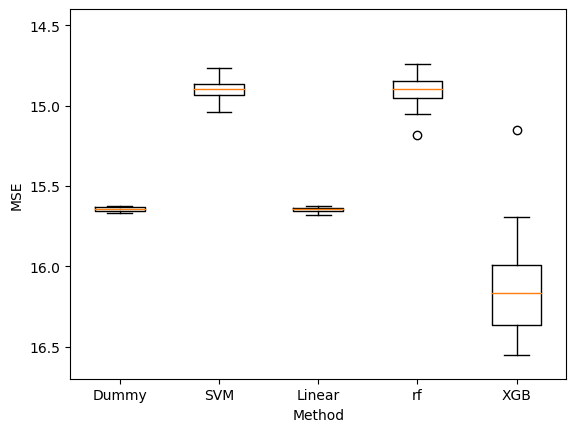

In [67]:
data = [ref_scores, svm_scores, lasso_scores, rf_scores, XGB_scores]
labels = ['Dummy', 'SVM', 'Linear', 'rf', 'XGB']

plt.boxplot(data, labels=labels)
plt.ylim(14.4,16.7)
plt.ylabel('MSE')
plt.xlabel('Method')
plt.gca().invert_yaxis()

plt.show()